In [1]:
import pandas as pd
import numpy as np
import time as tm
from numpy import RankWarning
import math
import random
import warnings
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from scipy.stats import rankdata
import scipy.stats as stats
from scipy.stats import genpareto, norm, poisson, expon, gamma
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.ticker import LogFormatter 
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import seaborn as sns
from Trend import *
from Wavelet import *
from Forecast import *
from NS_Cluster import *

2024-06-07 18:33:52.203632: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 18:33:52.242003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 18:33:52.242027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 18:33:52.242871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-07 18:33:52.248977: I tensorflow/core/platform/cpu_feature_guar

# Plotting Function Definitions

In [2]:
def plot_annual_max_series(time, time_series, data_type, data_unit, f_100, ann_percentile_95, percentile_50):
    """
    Plots the annual maximum time series and highlights specific statistical thresholds.

    Parameters:
    - time: The time or year associated with each data point.
    - time_series: The values of the time series to plot.
    - data_type: The type of data being plotted (e.g., 'Rainfall').
    - data_unit: The unit of measurement for the data (e.g., 'mm').
    - f_100: The 100-year flood threshold value.
    - ann_percentile_95: The 95th percentile value.
    - percentile_50: The 50th percentile daily flow value.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(time, time_series, marker='o', linestyle='-', color='b')
    plt.title(f'Annual Maximum {data_type} Over Years')
    plt.xlabel('Year')
    plt.ylabel(f'{data_type} {data_unit}')
    
    # Highlight statistical thresholds
    plt.axhline(y=f_100, color='r', linestyle='--', label=f"100 Year Flood: {f_100:.0f}")
    plt.axhline(y=ann_percentile_95, color='g', linestyle='--', label=f"95th Percentile: {ann_percentile_95:.0f}")
    plt.axhline(y=percentile_50, color='black', linestyle='--', label=f"50th Daily Percentile: {percentile_50:.0f}")
    
    # Text annotations
    plt.text(min(time), f_100, f"100 Year Flood: {f_100:.0f}", horizontalalignment='left', verticalalignment='bottom', color='r')
    plt.text(min(time), ann_percentile_95, f"20 Year Flood: {ann_percentile_95:.0f}", horizontalalignment='left', verticalalignment='bottom', color='g')
    plt.text(min(time), percentile_50, f"50th Percentile Daily Flow: {percentile_50:.0f}", horizontalalignment='left', verticalalignment='bottom', color='black')
    
    plt.legend()
    plt.show()

In [3]:
def plot_daily_values(df, var_interest, ann_step, base_signal, std_thres, f_100, percentile_50, data_unit):
    """
    Plots daily values against an annual extracted wavelet signal with statistical thresholds.

    Parameters:
    - df: DataFrame containing the daily data.
    - var_interest: String, the column name of interest in 'df'.
    - ann_step: DataFrame containing the annual step function data.
    - base_signal: Float, the baseline signal value for 'Ann_Signal'.
    - std_thres: String or float, standard threshold label for the baseline signal.
    - f_100: Float, the 100-year flood threshold value.
    - percentile_50: Float, the 50th percentile daily flow value.
    - data_unit: String, the unit of measurement for the data (e.g., 'm^3/s').
    """
    plt.figure(figsize=(10, 6))

    if std_thres != 'mean':
        std_thres = 'median' 
    
    # Plot the daily data
    plt.plot(df.index, df[var_interest], label='Daily Values', alpha=0.5)  # Adjusted for visibility
    
    # Step function for extracted signal
    plt.step(ann_step.index, ann_step['Ann_Signal'], label='Annual Signal (Step Function)', where='post')
    
    # Add horizontal lines for median, f_100, and 50th percentile values
    plt.axhline(y=base_signal, color='g', linestyle='--', label=f"Standard Annual Signal ({std_thres}): {base_signal:.0f} {data_unit}")
    plt.axhline(y=f_100, color='r', linestyle='--', label=f"100 Year Flood: {f_100:.0f} {data_unit}")
    plt.axhline(y=percentile_50, color='black', linestyle='--', label=f"50th Daily Percentile: {percentile_50:.0f} {data_unit}")
    
    plt.xlabel('Date')
    plt.ylabel(f'Discharge ({data_unit})')
    plt.title('Daily Values vs Annual Extracted Wavelet Signal')
    plt.legend()
    plt.show()

In [4]:
def plot_violin(data, group_by_columns, y_column, title, y_label, percentile_95=None, f_100=None):
    """
    Creates a violin plot for specified data aggregated by given columns.

    :param data: DataFrame containing the data to plot.
    :param group_by_columns: List of column names to group by.
    :param y_column: The name of the column to be plotted on the y-axis.
    :param title: The title of the plot.
    :param y_label: The label for the y-axis.
    :param percentile_95: Optional; the y-value at which to draw a horizontal line for the 95th percentile.
    :param f_100: Optional; the y-value at which to draw a horizontal line for the 100-year flood.

    """
    # Group the data and reset the index
    grouped_data = data.groupby(group_by_columns)[y_column].mean().reset_index()

    warnings.simplefilter(action='ignore', category=FutureWarning)
    plt.figure(figsize=(10, 6))

    # Create the violin plot
    ax = sns.violinplot(x=group_by_columns[0], y=y_column, data=grouped_data)

    plt.title(title)
    plt.xlabel(group_by_columns[0])
    plt.ylabel(y_label)

    # Optionally add threshold lines
    if percentile_95 is not None:
        plt.axhline(y=percentile_95, color='r', linestyle='--', label='95% Daily Percentile')
    if f_100 is not None:
        plt.axhline(y=f_100, color='b', linestyle='--', label='Empirical CDF 100 Year Flood')

    plt.xticks(rotation=45)

    # Annotation adjustments
    text_y_position = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05
    counts = grouped_data.groupby(group_by_columns[0]).size().reset_index(name='counts')
    for i, row in counts.iterrows():
        ax.text(i, text_y_position, str(int(row['counts'])), horizontalalignment='center', size='small', color='red', weight='semibold')

    plt.tight_layout()
    if percentile_95 is not None or f_100 is not None:
        plt.legend()

    plt.show()


def uni_plot_violin(data, group_by_columns, y_column, title, y_label, percentile_95=None, f_100=None):
    """
    Creates a violin plot for specified data aggregated by given columns.

    :param data: DataFrame containing the data to plot.
    :param group_by_columns: List of column names to group by.
    :param y_column: The name of the column to be plotted on the y-axis.
    :param title: The title of the plot.
    :param y_label: The label for the y-axis.
    :param percentile_95: Optional; the y-value at which to draw a horizontal line for the 95th percentile.
    :param f_100: Optional; the y-value at which to draw a horizontal line for the 100-year flood.

    """
    # Group the data and reset the index
    grouped_data = data.groupby(group_by_columns)[y_column].mean().reset_index()

    warnings.simplefilter(action='ignore', category=FutureWarning)
    plt.figure(figsize=(10, 6))

    # Create the violin plot
    ax = sns.violinplot(x=group_by_columns[0], y=y_column, data=grouped_data)

    plt.title(title)
    plt.xlabel(group_by_columns[0])
    plt.ylabel(y_label)

    # Optionally add threshold lines
    if percentile_95 is not None:
        plt.axhline(y=percentile_95, color='r', linestyle='--', label='95% Daily Percentile')
    if f_100 is not None:
        plt.axhline(y=f_100, color='b', linestyle='--', label='Empirical CDF 100 Year Flood')

    plt.xticks(rotation=45)

    # Annotation adjustments
    text_y_position = ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.05
    counts = grouped_data.groupby(group_by_columns[0]).size().reset_index(name='counts')
    for i, row in counts.iterrows():
        ax.text(i, text_y_position, str(int(row['counts'])), horizontalalignment='center', size='small', color='red', weight='semibold')

    plt.tight_layout()
    if percentile_95 is not None or f_100 is not None:
        plt.legend()

    plt.show()

In [5]:
def plot_storm_intensities(series, percentile_50, base_signal, f_100):
    """
    Plots storm intensities over the years as a violin plot and the progression of storm intensity by day.

    Parameters:
    - series: DataFrame containing storm data, including 'year', 'intensity', 'index_storms', and 'storm_day'.
    - percentile_50: The 50th percentile intensity value for reference in the plots.
    - percentile_95: The 95th percentile intensity value used for y-axis limit calculation.
    - f_100: The empirical CDF 100 year flood intensity value for reference in the plots.
    """
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Calculate desired y-axis limits
    y_min = 0
    y_max = max(series['Intensity'].max()*1.1, percentile_95, f_100)

    # Setting the overall figure size
    plt.figure(figsize=(20, 8))

    # ----- Plot 1: Violin Plot -----
    ax1 = plt.subplot(1, 2, 1)  # Create subplot 1
    sns.violinplot(x='year', y='daily_flow', data=series, cut=0)

    plt.title('Storm Intensities Over Years')
    plt.xlabel('Year')
    plt.ylabel('Intensity')
    plt.axhline(y=percentile_50, color='black', linestyle='--', label='50% Daily Percentile')
    plt.axhline(y=base_signal, color='green', linestyle='--', label='Signal Threshold')
    plt.axhline(y=f_100, color='r', linestyle='--', label='Empirical CDF 100 Year Flood')
    plt.xticks(rotation=45)
    plt.legend()

    # Set the same y-axis limits
    ax1.set_ylim([y_min, y_max])

    # ----- Plot 2: Line Plot -----
    ax2 = plt.subplot(1, 2, 2)  # Create subplot 2
    grouped = series.groupby(['year', 'storm_index'])
    unique_years = series['year'].unique()
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(unique_years)))  # Adjust colormap as needed
    year_color_map = dict(zip(unique_years, colors))

    for (year, index_storms), group in grouped:
        plt.plot(group['storm_day'], group['daily_flow'], color=year_color_map[year])

    plt.axhline(y=percentile_50, color='black', linestyle='--')
    plt.axhline(y=base_signal, color='green', linestyle='--')
    plt.axhline(y=f_100, color='r', linestyle='--')
    plt.title('Storm Intensity Progression by Day')
    plt.xlabel('Storm Day')
    plt.ylabel('Intensity')

    custom_lines = [Line2D([0], [0], color=year_color_map[year], lw=4) for year in unique_years]
    plt.legend(custom_lines, [f'Year {year}' for year in unique_years], loc='best', fontsize='small', title="Storm Years")

    # Set the same y-axis limits
    ax2.set_ylim([y_min, y_max])

    plt.tight_layout()
    plt.show()


def uni_plot_storm_intensities(series, percentile_50, percentile_95, f_100):
    """
    Plots storm intensities over the years as a violin plot and the progression of storm intensity by day.

    Parameters:
    - series: DataFrame containing storm data, including 'year', 'intensity', 'index_storms', and 'storm_day'.
    - percentile_50: The 50th percentile intensity value for reference in the plots.
    - percentile_95: The 95th percentile intensity value used for y-axis limit calculation.
    - f_100: The empirical CDF 100 year flood intensity value for reference in the plots.
    """
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # Calculate desired y-axis limits
    y_min = 0
    y_max = max(series['intensity'].max()*1.1, percentile_95, f_100)

    # Setting the overall figure size
    plt.figure(figsize=(20, 8))

    # ----- Plot 1: Violin Plot -----
    ax1 = plt.subplot(1, 2, 1)  # Create subplot 1
    sns.violinplot(x='year', y='intensity', data=series, cut=0)

    plt.title('Storm Intensities Over Years')
    plt.xlabel('Year')
    plt.ylabel('Intensity')
    plt.axhline(y=percentile_50, color='black', linestyle='--', label='50% Daily Percentile')
    plt.axhline(y=f_100, color='r', linestyle='--', label='Empirical CDF 100 Year Flood')
    plt.xticks(rotation=45)
    plt.legend()

    # Set the same y-axis limits
    ax1.set_ylim([y_min, y_max])

    # ----- Plot 2: Line Plot -----
    ax2 = plt.subplot(1, 2, 2)  # Create subplot 2
    grouped = series.groupby(['year', 'index_storms'])
    unique_years = series['year'].unique()
    colors = plt.cm.coolwarm(np.linspace(0, 1, len(unique_years)))  # Adjust colormap as needed
    year_color_map = dict(zip(unique_years, colors))

    for (year, index_storms), group in grouped:
        plt.plot(group['storm_day'], group['intensity'], color=year_color_map[year])

    plt.axhline(y=percentile_50, color='black', linestyle='--')
    plt.axhline(y=f_100, color='r', linestyle='--')
    plt.title('Storm Intensity Progression by Day')
    plt.xlabel('Storm Day')
    plt.ylabel('Intensity')

    custom_lines = [Line2D([0], [0], color=year_color_map[year], lw=4) for year in unique_years]
    plt.legend(custom_lines, [f'Year {year}' for year in unique_years], loc='best', fontsize='small', title="Storm Years")

    # Set the same y-axis limits
    ax2.set_ylim([y_min, y_max])

    plt.tight_layout()
    plt.show()

## General: Import, Export, Plotting

In [6]:
# Input file information
file_path = 'Data/Mississippi/Clinton_1873.csv'  # Define filepath for time series data
time_var = 'datetime'  # Time variable name in source file for time series data
var_interest = 'discharge_cfs'  # Variable of interest name in source file for time series data
temp_data_path = 'Data/Global/global_temp_NOAA_1850.csv'  # Define filepath for historical temperature data
ssp_data_path = 'Data/Global/ACC2_v2_Surf_Air_Temp_K.csv'  # Define filepath for ssp data

# Naming and formatting
data_type = "Streamflow" # Variable name in time series
data_unit = "cfs" # Variable unit in time series
data_source = "Clinton" # Data source, eg. Gauge/location
run_name = "Clinton_1873_KNN_MLE" # Name your file output
folder = 'Test'  # Specify desired output folder
sns.set_theme(style = 'white') # Set theme for all plotting

# Export options(Note that the code will always export a csv of all simulated storms)
save_signal = False  # Save the wavelet reconstructed signal in a separate csv with residuals from historical timeseries
save_forecast_signal = False  # Save the forecasted reconstructed signal in a separate csv
save_summ_exceeds = True  # Save summary data on threshold exceedances (needed for validation plots across entire period of interest)
record_dists = True  # Save the types of distributions fit during simulation
save_params = True # Save the nonstationary parameters used

# GENERAL
steps = 'default'  # time length for forecasting in years, default 20.
n_simulations = 1000 # default 1000

# Plotting
plot_raw = False
plot_LASSO = False
plot_transform = False
plot_wave = False
plot_reconstruct = False
plot_innovations = False
plot_BAIC = False
plot_wave_forecasts = False
plot_forecasts = True
plot_traj = False
plot_RV = False
plot_pair = False
plot_allsims = False
plot_onesim = True

## Parameter Inputs

In [7]:
# FORECAST
use_RF = 'default' # choice of using regularization term by random forest variable importance and threshold to use (bool, thres<float>). Default False, 0.
ssp_scenario = 'default' # choice of SSP emissions pathway (8.5, 7.0, 4.5, 2.6, 1.9). Default "4.5".
forecast_model = 'default' # choice of model ("ARIMA", "LSTM", "default"), default "ARIMA".

# CLUSTERING
nonstationary_type = 'default' # Define nonstationary type ('KNN', 'KNN_MLE', 'scaled','stationary'). Default "KNN".
sampling_type = 'default' # Decide whether to model frequency, intensity, duration jointly ('univariate', 'multivariate'). Default "multivariate".
KNN_sampling = 'default' # Decide whether to sample from KNN for final multivariate storm distribution. Default True.

## Hyperparameters

In [8]:
# OSCILLATIONS
sigtest = 'default' # Type of wavelet sigtest 'red' or 'white', default will plot both but use red for extraction
siglvl_wave = 0.95  # choice of significance level for wavelet extraction, default is 0.95.

# TREND
trend_max_lags = 5  # Set maximum temperature lags of interest for trend extraction
smoothing_frac = 1 # Fraction of data used for LOWESS smoothing. Default 1.

# FORECAST
AR_I_MA_lags = (3,3,3)  # Set maximum number of lags to consider for ARIMA fitting (AR, I, MA). Default (3,3,3).
LSTM_seq_len = 3 # Set forecast sequence length. Default 3.
LSTM_epochs = 100 # Set number of training epochs. Default 100.
LSTM_units = 40 # Set number of LSTM nodes in layer. Default 40.
LSTM_act = 'relu' # Set activitation function. Default 'relu'.

# CLUSTERING
std_thres = 'default'  # choice of threshold for standard exceedances ("median", "mean"), default of median.
siglvl_KS = 0.05  # choice of significance level for univariate parameterization using KS Test, default is 5%.
siglvl_chi_sq = 0.05  # choice of significance level for univariate parameterization using Chi Squared, default is 5%.
signal_dist = 'default' # Set dist to extract intensities ('Expon', 'Gamma' or 'GPD'). Default is Exponential.
intensity_dist = 'default' # Set dist to extract intensities ('Expon', 'Gamma' or 'GPD'). Default is Exponential.
duration_dist = 'default' # Set dist to extract durations ('Expon', 'Gamma', or 'GPD'). Default is Exponential.
frequency_dist = 'default' # Set dist to extract frequencies ('Poisson'). Default is Poisson.
scale_factor = 1  # Adjust scaling factor if using 'scaled' nonstationarity. Default is 1.
dist_fix = False # Decide whether to fix distribution fits. If True dists are fixed to those specified, otherwise defaults on fit based on KS/Chi Squared Test.

In [9]:
# Establish defaults
# GENERAL
if steps == 'default':
    steps = 20

# FORECAST
if use_RF == 'default':
    use_RF = False, 0
if ssp_scenario == 'default':
    ssp_scenario = '4.5'
if forecast_model != 'LSTM':
    forecast_model = 'ARIMA'

# CLUSTERING
if signal_dist == 'default':
    signal_dist = 'Expon'
if intensity_dist == 'default':
    intensity_dist = 'Expon'
if duration_dist == 'default':
    duration_dist = 'Expon'
if frequency_dist == 'default':
    frequency_dist = 'Poisson'

if KNN_sampling == 'default':
    KNN_sampling = True
if sampling_type == 'univariate':
    KNN_sampling = False
    if nonstationary_type == 'scaled' or nonstationary_type == 'stationary':
        nonstationary_type = 'default'
if nonstationary_type == 'default' or nonstationary_type == 'KNN' or nonstationary_type == 'KNN_MLE':
    dist_fix = True  # Distributions fixed for KNN-signal sampling

## Data load and preprocess

In [10]:
# Load the data with explicit date parsing
df = pd.read_csv(file_path)

# Convert 'datetime' to datetime type if it's not already
df[time_var] = pd.to_datetime(df[time_var])

# Convert the index to a Datetime Index explicitly
df.index = pd.to_datetime(df[time_var])

# Resample to annual frequency and take the maximum daily
annual_max = df[var_interest].resample('YE').max()

# Extract the year from each date
years = df[time_var].dt.year

# Find the unique years
time = np.unique(years)

# Convert the series to a DataFrame
annual_max_df = annual_max.to_frame(name='annual_max_streamflow')

# Identify annual maxima
time_series = annual_max_df['annual_max_streamflow'].values

In [11]:
# Save original statistics for dataseries
time = np.unique(years)
og_data = time_series
og_mean = np.mean(time_series)
og_std = np.std(time_series)
lg_mean = np.mean(np.log(time_series))
lg_std = np.std(np.log(time_series))

In [12]:
# Calculate the 95th percentile of annual maximum
ann_percentile_95 = np.percentile(time_series, 95)

# Calculate the 95th Percentile of daily data
percentile_95 = np.percentile(df[var_interest], 95)

# Calculate the 95th Percentile of daily data
percentile_50 = np.percentile(df[var_interest], 50)

# Calculate 100 year flood
f_100 = np.exp(norm.ppf(1-1/100, loc=lg_mean, scale=lg_std))

print(f"100 Year Flood: {f_100:.2f}")
print(f"20 Year Flood: {ann_percentile_95:.2f}")

if plot_raw:
    # Plot ann max time series 
    plot_annual_max_series(time, time_series, data_type, data_unit, f_100, ann_percentile_95, percentile_50)

100 Year Flood: 303849.76
20 Year Flood: 235900.00


In [13]:
# Load historical temperature data
# Create a DataFrame with just "year" and "anomaly" columns
temp_df = pd.read_csv(temp_data_path, skiprows=4)

temp_df_selected = temp_df.iloc[:, [0, 1]]  # Correcting column selection based on actual data
temp_df_selected.columns = ['Year', 'Anomaly']  # Renaming columns for clarity

# Calculate the yearly average concentration (if not already)
yearly_avg_concentration = temp_df_selected.groupby('Year').mean().reset_index

In [14]:
# Load the SSP projected temperature data
# Create a DataFrame with just "year" and "anomaly" columns
ssp_df = pd.read_csv(ssp_data_path)

# Specify forecast time
forecast_time = pd.DataFrame(list(range(max(time)-trend_max_lags,max(time)+steps)), columns=['Year'])

ssp_df_selected = ssp_df.iloc[:, [0, 15, 16, 17, 18, 23]]  # Correcting column selection based on actual data
ssp_df_selected.columns = ['Year', '1.9', '2.6', '4.5', '7.0', '8.5']  # Renaming columns for clarity

## Trend extraction

In [15]:
# Fit an exponential smoother to the timeseries data for detrending
smoothed = fit_loess_smoothing(time_series, frac = smoothing_frac)
detrended = time_series - smoothed

# Convert the lists into a DataFrame
smoothed_df = pd.DataFrame({
    "Year": time,
    "Smoothed": smoothed,
    "Original_Data": og_data
})

# Merge the two DataFrames on "Year" with an inner join to include only years present in both
merged_df = pd.merge(temp_df_selected, smoothed_df, on="Year", how="inner")

# Merge the two DataFrames on "Year" with an inner join to include only years present in both
forecast_merged_df = pd.merge(forecast_time, ssp_df_selected, on="Year", how="inner")

In [16]:
# Adding lags for 'Smoothed' and temp 'Anomaly' values
v_names = ['Year', 'Anomaly']
for i in range(1,trend_max_lags+1):
    merged_df[f'temp_lag{i}'] = merged_df['Anomaly'].shift(i)
    forecast_merged_df[f'temp_lag{i}'] = forecast_merged_df[ssp_scenario].shift(i)
    v_names.append(f'temp_lag{i}')

# Add column 'Anomaly' for SSP scenario of interest
forecast_merged_df['Anomaly'] = forecast_merged_df[ssp_scenario]

# Dropping rows with NaN values resulting from lagging
merged_df.dropna(inplace=True)
forecast_merged_df.dropna(inplace=True)

# Define features and target variable
X = merged_df[v_names]
X_forecast = forecast_merged_df[v_names]
y = merged_df['Smoothed']

if use_RF[0]:
    RF_thres = use_RF[1]
    significant_vars = random_forest_analysis(X, y, v_names, trend_max_lags, var_interest, RF_thres)['Significant Variables']
else:
    significant_vars = v_names

In [17]:
# Check if only lag variables are significant
only_yr_sig = all(var == 'Year' for var in significant_vars)

# Extract significant variables for regression
X_sig = X[significant_vars]
X_forecast = X_forecast[significant_vars]
y = merged_df['Smoothed']  # Target variable, already defined

if only_yr_sig:
    # Fit and plot simple linear regression if only time is significant
    forecast_lin, intercept = linear_forecast(smoothed, steps, time, og_data, data_type, plot=True)
else:
    # Fit LASSO regression if there are multiple covariates
    forecast_lin=perform_lasso_regression(X_sig, y, X_forecast, merged_df, data_type, data_unit, name=data_source, plot_LASSO=plot_LASSO)['predictions']

Best alpha found: 220.79870374719403
RMSE: 3381.939714290506
LASSO weights for each covariate:
Year: 54.23527062949076
Anomaly: 4696.035646799509
temp_lag1: 649.7774829136574
temp_lag2: 5419.729811595409
temp_lag3: 463.74790390807584
temp_lag4: 0.0
temp_lag5: 281.14397544099387


## Wavelet oscillatory extraction 

In [18]:
shift, time_series, lambda_boxcox = transform_data(time_series, detrended, data_type, plot=plot_transform)

In [19]:
# wavelet transform
warnings.filterwarnings('ignore', 'divide by zero encountered in divide', RuntimeWarning)
wlt = wavelet(time_series)
Cw = CI(wlt, time_series, siglvl_wave, "r")
C = CI(wlt, time_series, siglvl_wave, "w")

# Global Wavelet Spectrum
plt_dataset = {
    'Time': time,
    'Period': wlt['period'],
    'Avg_Power': wlt['avg_power'],
    'Power': wlt['power'],
    'COI': wlt['coi'],
    'W_noise': C['sig'],
    'R_noise': Cw['sig']
}

Red Noise AR1 Coefficient: 0.928389214767694


In [20]:
if plot_wave:
    wavelet_plot(plt_dataset, siglvl_wave, data_source, sigtest)

In [21]:
if sigtest == 'white':
    print("White Noise Sig Test Results")
    reconstruct, sig_scales = reconstruct(C, time_series)
else:
    print("Red Noise Sig Test Results")
    reconstruct, sig_scales = reconstruct(Cw, time_series)

Red Noise Sig Test Results
Significant scales:
[ 2.    2.03  2.07  2.11  2.14  2.18  2.22  2.26  2.3   2.34  2.38  2.42
  2.46  2.51  2.55  2.59  2.64  2.69  2.73  2.78  2.83  2.88  2.93  2.98
  3.03  3.08  3.14  3.19  3.25  3.31  3.36  3.42  3.48  3.54  3.61  3.67
  3.73  3.8   3.86  3.93  4.    4.07  4.14  4.21  4.29  4.36  4.44  4.52
  4.59  4.68  4.76  4.84  4.92  5.01  5.1   5.19  5.28  5.37  5.46  5.56
  5.66  5.76  5.86  5.96  6.06  6.17  6.28  6.39  6.5   6.61  6.73  6.84
  6.96  7.09  7.21  7.34  7.46  7.59  7.73  7.86  8.    8.14  8.28  8.43
  8.57  8.72  8.88  9.03  9.19  9.35  9.51  9.68  9.85 10.02 10.2  10.37
 10.56 10.74 10.93 11.12 11.31]


In [22]:
if plot_reconstruct:
    plot_reconstructed_series(time_series, reconstruct, dates=time)
if plot_innovations:
    plot_distribution_of_innovations(time_series, reconstruct)

## Forecasting

In [23]:
# Suppress common warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.*", category=UserWarning, module='statsmodels.*')
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.*", category=UserWarning, module='statsmodels.*')

if forecast_model == 'LSTM':
    # Use LSTM to forecast the reconstructed aggregate
    forecast_LSTM, LSTM_log_mse = fit_LSTM(reconstruct, time, steps, time_series, seq_len = LSTM_seq_len, epochs = LSTM_epochs, units = LSTM_units, act = LSTM_act, plot=plot_wave_forecasts)
    fin_forecast = forecast_LSTM.flatten()
else:
    # Fit an aggregate ARMA for the reconstructed aggregate
    sum_ARMA, forecast_params, AIC, BIC = fit_arima_model(reconstruct, max_ar=AR_I_MA_lags[0], max_ma=AR_I_MA_lags[1], max_d=AR_I_MA_lags[2], plot=plot_wave_forecasts)
    
    # Plot and simulate time series with aggregate ARMA
    forecasts_agg = np.empty((n_simulations, 1, steps))
    forecasts_agg[:] = np.nan
    
    model = sum_ARMA
    print(model.summary())
    
    for j in range(n_simulations):       
        # Generate simulations and store in forecasts array
        forecast = model.simulate(anchor='end', nsimulations=steps)
        forecasts_agg[j, 0, :] = forecast

    if plot_wave_forecasts:
        plot_all_forecasts(reconstruct, forecasts_agg, time_series)
    
    fin_forecast = forecasts_agg[:,0,:]

Log Mean Squared Error: -4.396201133728027


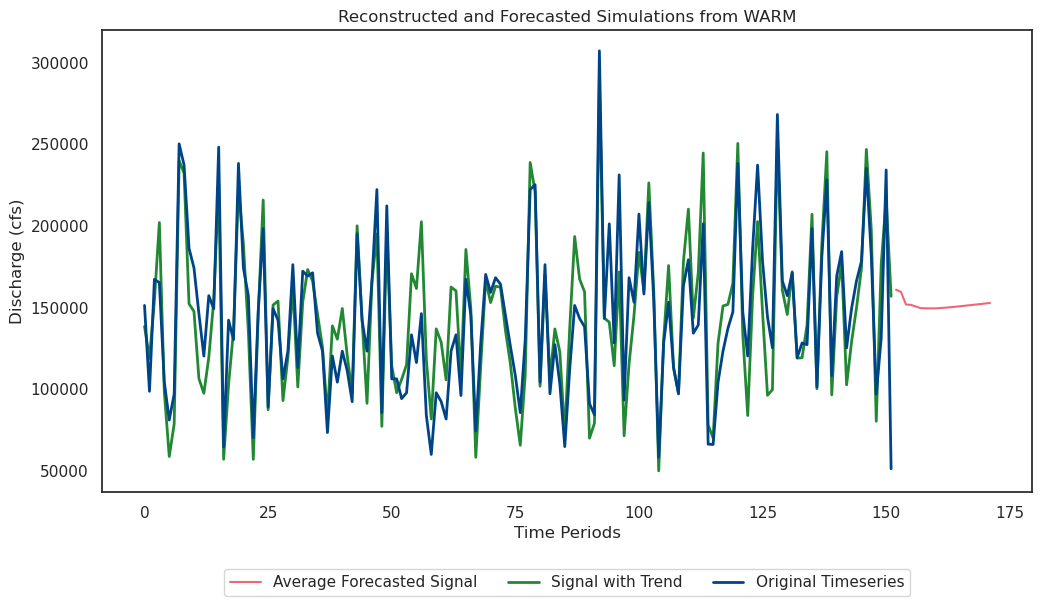

In [24]:
# Now we want to reverse our transforms to reproduce a similar signal
# First we perform inverse boxcox
signal_ibc = inv_boxcox(reconstruct.clip(min=0), lambda_boxcox)-shift
forecasted_agg_ibc = inv_boxcox(fin_forecast.clip(min=0), lambda_boxcox)-shift

# Next we add the trend back to the data
signal_ibc = signal_ibc + smoothed

# Calculate residuals
residuals = signal_ibc - og_data

# Convert arrays to DataFrame
reconstruct_df = pd.DataFrame({'Year': time,'Ann_Signal': signal_ibc, 'Residuals': residuals})

# Save to CSV
if save_signal:
    reconstruct_df.to_csv(f"{folder}/Signal_{run_name}.csv", index=False)

if forecast_model == 'LSTM':
    forecasted_agg_ibc = forecasted_agg_ibc + forecast_lin
    reconstruct_forecast = reconstructed_forecasts(signal_ibc, forecasted_agg_ibc, og_data, data_unit, forecast_model, run_name, folder, plot=plot_forecasts, save=save_forecast_signal)
else:
    for i in range(forecasted_agg_ibc.shape[0]):
        forecasted_agg_ibc[i,:] = forecasted_agg_ibc[i,:] + forecast_lin
    
    # Plot sims reconsturcted with single ARMA
    reconstruct_forecast = reconstructed_forecasts(signal_ibc, forecasted_agg_ibc, og_data, data_unit, forecast_model, run_name, folder, plot=plot_forecasts, save=save_forecast_signal)
    if save_forecast_signal:
        forecasted_agg_ibc.to_csv(f"{folder}/All_ARIMA_Signal_Forecast_{run_name}.csv", index=False)

## Sub-annual clustering parameterization

In [25]:
# Converting annual signal to a step function over the same period as daily values for plotting
ann_step = df.copy()  # Assuming og_daily_data has 'datetime' as its index
ann_step['Ann_Signal'] = np.nan  # Initialize the column

# Loop over each year and signal in the annual data
for year, signal in zip(reconstruct_df['Year'], reconstruct_df['Ann_Signal']):
    # Correctly assign the signal to the 'Ann_Signal' column for the corresponding year
    ann_step.loc[ann_step.index.year == year, 'Ann_Signal'] = signal

# Calculate the median value of the 'Ann_Signal' column in 'ann_step'
if std_thres == 'mean':
    base_signal = ann_step['Ann_Signal'].mean()
else:
    base_signal = ann_step['Ann_Signal'].median()

signal_sd = ann_step['Ann_Signal'].std()

if plot_raw:
    # Plot daily values and annual signal
    plot_daily_values(df, var_interest, ann_step, base_signal, std_thres, f_100, percentile_50, data_unit)

In [26]:
# Extract historic flood events
if sampling_type == 'univariate':
    df, result_df, cluster_sizes = index_and_count_clusters(ann_step, var_interest, base_signal, 'Exceeds_Std')
else:
    result_df, multivar_signal = extract_exceedance_clusters(df, reconstruct_df, var_interest, base_signal)

cluster_dict_std, sigma0_std = trajectory_dict_plot(df, plot_traj)

if save_summ_exceeds:
    result_df.to_csv(f"{folder}/Standard_Summary_Exceedances_{run_name}.csv", index=False)

if plot_pair:
    # Plot original distribution of storm signal, frequence, intensity, and duration
    if sampling_type == 'univariate':
        FIDS_pairplot(result_df, jitter_col=['Frequency'],columns=['Frequency', 'Intensity','Duration'])
    else:
        FIDS_pairplot(result_df, jitter_col=['Frequency'],columns=['Signal', 'Frequency', 'Intensity','Duration'])

In [27]:
# Fit univariate distributions
if dist_fix == True:
    dist_fix = -1
else:
    dist_fix = 0

if sampling_type == 'univariate':
    freq_params, og_frequency_samples, frequency_dist, freq_test = fit_frequency_distribution(result_df['Frequency'], frequency_dist, plot_RV, "Frequency", 100, status=dist_fix) #result_df.groupby('Year')['Frequency'].mean().reset_index()['Frequency']
    intensity_params, og_intensity_samples, intensity_dist, int_test = fit_intensity_distribution(result_df['Intensity'][result_df['Frequency'] > 0], intensity_dist, plot_RV, "Intensity", 100, status=dist_fix)
    duration_params, og_duration_samples, duration_dist, dur_test = fit_duration_distribution(result_df['Duration'][result_df['Frequency'] > 0], duration_dist, plot_RV, "Duration", 100, status=dist_fix)

    dist_params = {
        'intensity': (intensity_params, intensity_dist),
        'duration': (duration_params, duration_dist),
        'frequency': (freq_params, frequency_dist),
    }

    dists = pd.DataFrame({
        'Model_Component': list(dist_params.keys())+['Forecast_Model'],
        'Model_Fit': [intensity_dist,duration_dist,frequency_dist, forecast_model if (forecast_model == 'LSTM') else forecast_model + f'({forecast_params})'],
        'Model_Evaluation_1': ['KS Test', 'Chi-Squared Test', 'Chi-Squared Test', 'MLSE' if (forecast_model == 'LSTM') else 'AIC'],
        'Evaluation_Value_1': [int_test[0], dur_test[0], freq_test[0], LSTM_log_mse if (forecast_model == 'LSTM') else AIC],
        'Model_Evaluation_2': ['p_val', 'p_val', 'p_val', 'N/A' if (forecast_model == 'LSTM') else 'BIC'],
        'Evaluation_Value_2': [int_test[1], dur_test[1], freq_test[1], LSTM_log_mse if (forecast_model == 'LSTM') else BIC],
    })
    
else:
    freq_signal_params, freq_og_signal_samples, freq_signal_dist, freq_sig_test = fit_intensity_distribution(result_df['Signal'], signal_dist, plot_RV, "Signal", 100, status=dist_fix) #result_df.groupby('Year')['Signal'].mean().reset_index()['Signal'][result_df['Signal'] > 0]
    freq_params, og_frequency_samples, frequency_dist, freq_test = fit_frequency_distribution(result_df['Frequency'], frequency_dist, plot_RV, "Frequency", 100, status=dist_fix) #result_df.groupby('Year')['Frequency'].mean().reset_index()['Frequency']
    signal_params, og_signal_samples, signal_dist, sig_test = fit_intensity_distribution(result_df['Signal'][result_df['Frequency'] > 0], signal_dist, plot_RV, "Signal", 100, status=dist_fix) #result_df.groupby('Year')['Signal'].mean().reset_index()['Signal'][result_df['Signal'] > 0]
    intensity_params, og_intensity_samples, intensity_dist, int_test = fit_intensity_distribution(result_df['Intensity'][result_df['Frequency'] > 0], intensity_dist, plot_RV, "Intensity", 100, status=dist_fix)
    duration_params, og_duration_samples, duration_dist, dur_test = fit_duration_distribution(result_df['Duration'][result_df['Frequency'] > 0], duration_dist, plot_RV, "Duration", 100, status=dist_fix)

    dist_params = {
        'signal_freq': (freq_signal_params, freq_signal_dist),
        'signal': (signal_params, signal_dist),
        'intensity': (intensity_params, intensity_dist),
        'duration': (duration_params, duration_dist),
        'frequency': (freq_params, frequency_dist),
    }

    dists = pd.DataFrame({
        'Model_Component': list(dist_params.keys())+['Forecast_Model'],
        'Model_Fit': [freq_signal_dist,signal_dist,intensity_dist,duration_dist,frequency_dist, forecast_model if (forecast_model == 'LSTM') else forecast_model + f'({forecast_params})'],
        'Model_Evaluation_1': ['KS Test', 'KS Test', 'KS Test', 'Chi-Squared Test', 'Chi-Squared Test', 'Log_MSE' if (forecast_model == 'LSTM') else 'AIC'],
        'Evaluation_Value_1': [freq_sig_test[0], sig_test[0], int_test[0], dur_test[0], freq_test[0], LSTM_log_mse if (forecast_model == 'LSTM') else AIC],
        'Model_Evaluation_2': ['p_val', 'p_val', 'p_val', 'p_val', 'p_val', 'N/A' if (forecast_model == 'LSTM') else 'BIC'],
        'Evaluation_Value_2': [freq_sig_test[1], sig_test[1], int_test[1], dur_test[1], freq_test[1], LSTM_log_mse if (forecast_model == 'LSTM') else BIC],
    })

if record_dists:
    dists.to_csv(f"{folder}/Dists_{run_name}.csv", index=False)

KS Test Statistic: 0.35087140475206113, p-value: 7.218458279781356e-21
Fit enforced by user.
Chi-Squared Test Statistic: 18.828475049417833, p-value: 0.0008493292292991628
Fit enforced by user.
KS Test Statistic: 0.45218347674775217, p-value: 4.0071852210965616e-20
Fit enforced by user.
KS Test Statistic: 0.5592360350680932, p-value: 1.833839999920396e-31
Fit enforced by user.
Chi-Squared Test Statistic: 22.87843611160323, p-value: 0.1953048632502164
Fit enforced by user.


In [28]:
# Initialize forecasting and signal parameterization vector
max_time = np.max(time)
    
# Create a 2D array for the 'year' column
years = np.arange(1, steps + 1) + max_time  # Create list of years to forecast for

# Repeat 'years' for each simulation (y times)
year_column = np.tile(years, n_simulations)

# Repeat simulation indices for each year (x times)
sim_column = np.repeat(np.arange(n_simulations), steps)

if forecast_model == 'LSTM':
    signal_column = np.tile(fin_forecast, n_simulations)
else:
    # Flatten the forecasted_agg_ibc array for the 'signal' column
    signal_column = forecasted_agg_ibc.flatten()
    
# Create the DataFrame
future_signal = pd.DataFrame({
    'year': year_column,
    'sim': sim_column,
    'signal': signal_column
})

In [29]:
# Specify parameters for univariate fits based on sampling and nonstationarity type
if sampling_type != 'univariate':
    if nonstationary_type == 'KNN':
        future_signal = KNN(future_signal, multivar_signal)
        dist_params['signal'] = (signal_params, 'Expon')
        dist_params['signal_freq'] = (freq_signal_params, 'Expon')
        dist_params['intensity'] = (intensity_params, 'Expon')
        dist_params['duration'] = (duration_params, 'Expon')
        print("Nonstationary Signal Parameters Derived Successfully.")
    elif nonstationary_type == 'KNN_MLE':
        future_signal = KNN_MLE(future_signal, multivar_signal)
        dist_params['signal'] = (signal_params, 'Expon')
        dist_params['signal_freq'] = (freq_signal_params, 'Expon')
        dist_params['intensity'] = (intensity_params, 'Expon')
        dist_params['duration'] = (duration_params, 'Expon')
        print("Nonstationary Signal Parameters Derived Successfully.")
    elif nonstationary_type == 'scaled':
        min_sig = min(np.min(result_df['Signal']), np.min(future_signal['signal']))
        max_sig = max(np.max(result_df['Signal']), np.max(future_signal['signal']))
        scaled = (future_signal['signal'] - min_sig) / (max_sig - min_sig) + 0.5
        scaled = scaled*scale_factor 
        if signal_dist != 'Logspline':
            future_signal['Scale_Sig'] = scaled*signal_params['scale']
        if intensity_dist != 'Logspline':
            future_signal['Scale_Int'] = scaled*intensity_params['scale']
        if duration_dist != 'Logspline':    
            future_signal['Scale_Dur'] = scaled*duration_params['scale']
        if frequency_dist != 'Logspline':    
            future_signal['Scale_Freq'] = scaled*freq_params['lambda']
        print("Nonstationary Signal Parameters Derived Successfully.")
    else:
        if signal_dist != 'Logspline':
            future_signal['Scale_Sig'] = 1*signal_params['scale']
        if intensity_dist != 'Logspline':
            future_signal['Scale_Int'] = 1*intensity_params['scale']
        if duration_dist != 'Logspline':
            future_signal['Scale_Dur'] = 1*duration_params['scale']
        if frequency_dist != 'Logspline':
            future_signal['Scale_Freq'] = 1*freq_params['lambda']
        print("Stationary Signal Parameters Derived Successfully.")

    if save_params:
        future_signal.to_csv(f"{folder}/Params_{run_name}.csv", index=False)

Stationary Signal Parameters Derived Successfully.


## Adapted Neyman-Scott Process storm generation

In [30]:
warnings.filterwarnings('ignore')
start_time = tm.time()  # Record the start time before the simulation begins

if sampling_type == 'univariate':
    all_sims, traj_parent = uni_adapted_NS_Process(n_simulations=n_simulations, 
                       years=years,
                       forecasted_agg_ibc=forecasted_agg_ibc,
                       reconstruct_forecast=reconstruct_forecast,
                       summary_std=result_df,
                       cluster_dict_std=cluster_dict_std,
                       folder=folder,
                       run_name=run_name,
                       base_signal=base_signal,
                       percentile_50=percentile_50,
                       forecast_model=forecast_model,
                       intensity_dist=intensity_dist,
                       intensity_params=intensity_params,
                       dur_dist=duration_dist,
                       duration_params=duration_params,
                       KNN_Type=nonstationary_type,
                       steps = steps)
    end_time = tm.time()  # Record the end time after the simulation ends
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    print(f"{n_simulations} Simulations completed in {elapsed_time:.2f} seconds.")

else:
    all_data = []
    for sim in range(n_simulations):
        fut_sig = future_signal[future_signal['sim'] == sim].reset_index(drop=True)
        if forecast_model == 'LSTM':
            FS_parent = simulate_storm_frequencies(sim, years, fut_sig, result_df, dist_params, KNN_sampling=KNN_sampling, plot_pair=False, plot_RV=False)
        else:
            FS_parent = simulate_storm_frequencies(sim, years, fut_sig, result_df, dist_params, KNN_sampling=KNN_sampling, plot_pair=False, plot_RV=False)
        parent = expand_rows_based_on_frequency(FS_parent, sim)
        FIDS_parent = simulate_storm_statistics(sim, parent, result_df, fut_sig, dist_params, KNN_sampling=KNN_sampling, plot_pair=False, plot_RV=False)
        traj_parent = storm_trajectories(FIDS_parent, bootstrap_curve, cluster_dict_std, plot=plot_traj)
        all_data.append(traj_parent)
        if (sim+1) % 100 == 0:
            end_time = tm.time()  # Record the end time after the simulation ends
            elapsed_time = end_time - start_time  # Calculate the elapsed time
            print(f"Simulation {sim+1} completed out of {n_simulations} in {elapsed_time:.2f} seconds.")
        
    end_time = tm.time()  # Record the end time after the simulation ends
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    print(f"{n_simulations} Simulations Complete. Run time: {elapsed_time:.2f} seconds.")
    
    # Concatenate all DataFrames in the list at once
    all_sims = pd.concat(all_data, ignore_index=True)
    
    # Convert year and sim columns to integers
    all_sims = all_sims.astype({'sim': 'int', 'year': 'int'})
    all_sims = all_sims[['sim', 'year', 'storm_index', 'unique_storm_id', 'signal', 'Frequency', 'Intensity', 'Duration', 'storm_day', 'daily_flow']]  # Reorder columns
    
    # Sort the DataFrame by 'unique_storm_id'
    all_sims = all_sims.sort_values(by='unique_storm_id')
    # Save to CSV
    all_sims.to_csv(f"{folder}/All_Sims_{run_name}.csv", index=False)

Simulation 100 completed out of 1000 in 15.97 seconds.
Simulation 200 completed out of 1000 in 32.33 seconds.
Simulation 300 completed out of 1000 in 48.62 seconds.
Simulation 400 completed out of 1000 in 64.69 seconds.
Simulation 500 completed out of 1000 in 80.49 seconds.
Simulation 600 completed out of 1000 in 96.45 seconds.
Simulation 700 completed out of 1000 in 112.98 seconds.
Simulation 800 completed out of 1000 in 128.68 seconds.
Simulation 900 completed out of 1000 in 145.40 seconds.
Simulation 1000 completed out of 1000 in 161.90 seconds.
1000 Simulations Complete. Run time: 161.90 seconds.


## Summary Plots

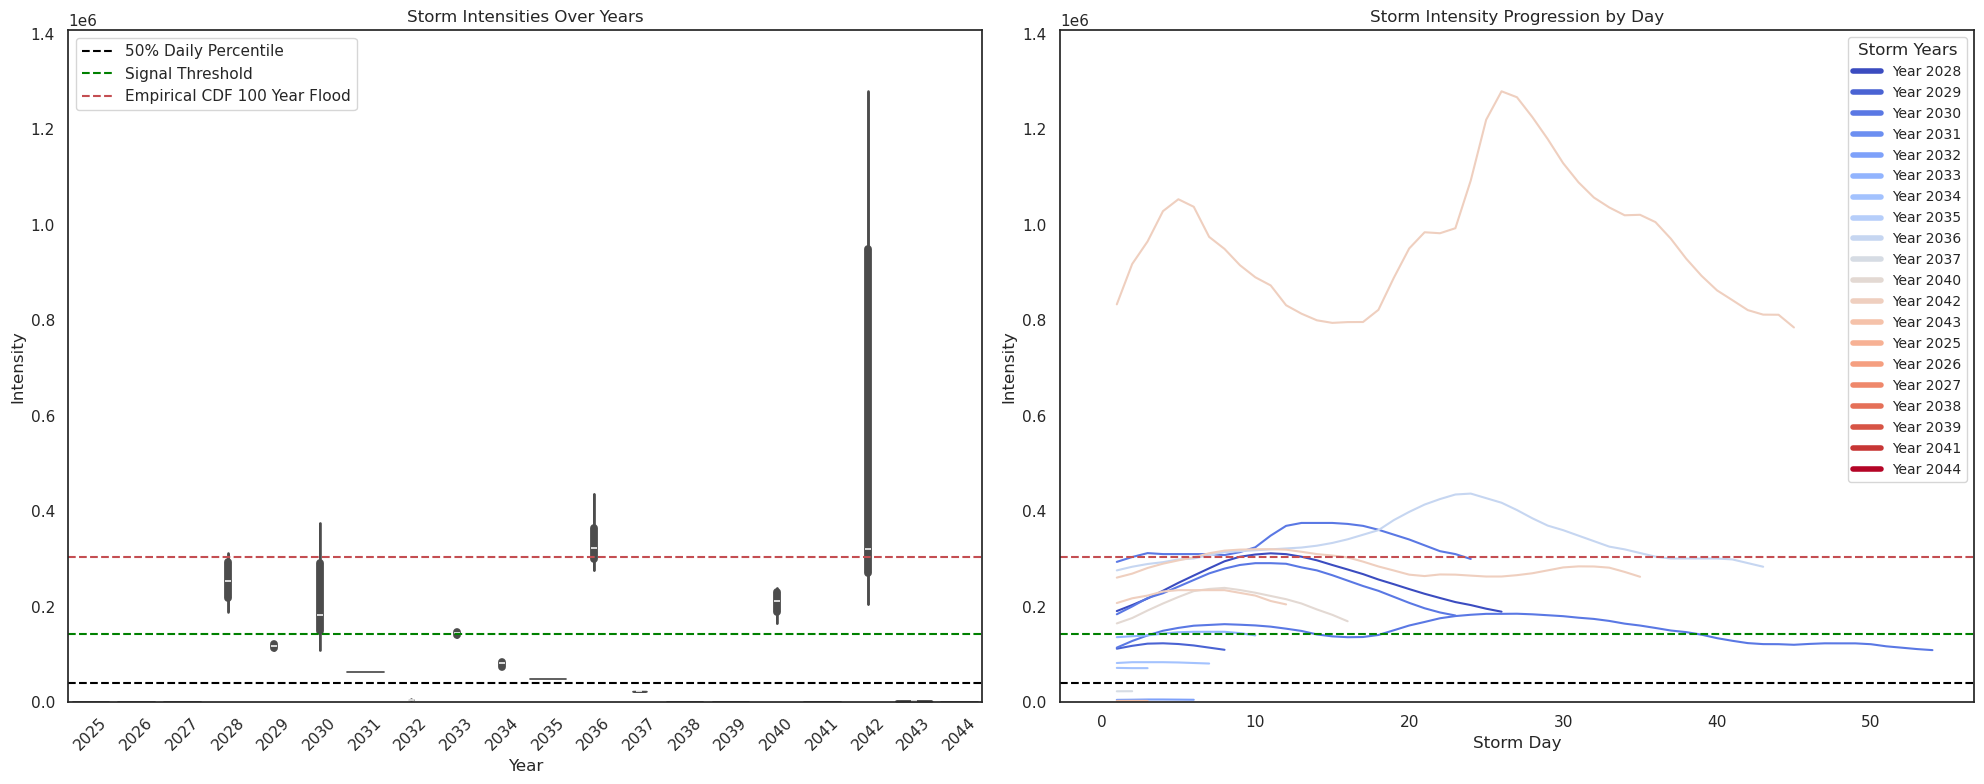

All Done!


In [31]:
if plot_allsims:
    if sampling_type == 'univariate':
        uni_plot_violin(
            data=all_sims, 
            group_by_columns=['year', 'sim'], 
            y_column='storm_max_intensity', 
            title='Maximum Annual Storm Intensities Over Time, All Simulations', 
            y_label='Max Annual Intensity', 
            percentile_95=percentile_95,  # Replace with your actual value
            f_100=f_100  # Replace with your actual value
        )
        
        # Duration over all sims
        uni_plot_violin(
            data=all_sims, 
            group_by_columns=['year', 'sim'], 
            y_column='storm_duration', 
            title='Average Annual Storm Duration Over Time, All Simulations', 
            y_label='Storm Duration (Days)'
        )
        
        
        # Frequency over all sims
        uni_plot_violin(
            data=all_sims, 
            group_by_columns=['year', 'sim'], 
            y_column='no_storms', 
            title='Annual Storm Frequencies Over Time, All Simulations', 
            y_label='Number of Storms'
        )
    else:
        # Intensity over all sims
        plot_violin(
            data=all_sims, 
            group_by_columns=['year', 'sim'], 
            y_column='Intensity', 
            title='Maximum Annual Storm Intensities Over Time, All Simulations', 
            y_label='Max Annual Intensity', 
            percentile_95=percentile_95,  # Replace with your actual value
            f_100=f_100  # Replace with your actual value
        )
        
        # Duration over all sims
        plot_violin(
            data=all_sims, 
            group_by_columns=['year', 'sim'], 
            y_column='Duration', 
            title='Average Annual Storm Duration Over Time, All Simulations', 
            y_label='Storm Duration (Days)'
        )
        
        
        # Frequency over all sims
        plot_violin(
            data=all_sims, 
            group_by_columns=['year', 'sim'], 
            y_column='Frequency', 
            title='Annual Storm Frequencies Over Time, All Simulations', 
            y_label='Number of Storms'
        )
    
if plot_onesim:
    if sampling_type == 'univariate':
        uni_plot_storm_intensities(traj_parent, percentile_50, base_signal, f_100)
    else:
        plot_storm_intensities(traj_parent, percentile_50, base_signal, f_100)

print("All Done!")